In [2]:
import torch 
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

filepath = r"C:\Users\vansh\AI and ML reading material\MakeMore-Implementing NLP models\names.txt"

In [3]:
#read in the dataset
words = open(filepath, 'r').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [4]:
print("The total number of words in the dataset are: ",len(words))

The total number of words in the dataset are:  32033


In [5]:
#build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {c:i+1 for i, c in enumerate(chars)}
stoi['.'] = 0
itos = {i:c for c, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [6]:
#build the dataset
block_size = 3 #context_length

def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0]*block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape), print(Y.shape)

    return X, Y

import random
random.seed(3125)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182619, 3])
torch.Size([182619])
torch.Size([22804, 3])
torch.Size([22804])
torch.Size([22723, 3])
torch.Size([22723])


In [12]:
#MLP revisited 
n_embed = 10 #number of embedding dimensions
n_hidden = 200 #number of hidden units

g = torch.Generator().manual_seed(12345)
C = torch.randn((vocab_size, n_embed), generator=g, requires_grad=True) #generate the embeddings for each of the 27 characters
W1 = torch.randn((n_embed*block_size, n_hidden), generator=g, requires_grad=True) #weight matrix of the first layer
b1 = torch.randn(n_hidden, generator=g, requires_grad=True)
W2 = torch.randn((n_hidden, vocab_size), generator=g, requires_grad=False) * 0.01 
b2 = torch.randn(vocab_size, generator=g, requires_grad=False) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


In [13]:
import torch.nn.functional as F
#same optimization as last time
max_steps = 20000
batch_size = 32
lossi=[]

for i in range(max_steps):
    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    #forward pass
    emb = C[Xb] #embed the characters into the vectors
    embcat = emb.view(emb.shape[0], -1) #concatenate vectors
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact) #hidden layer
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb) #loss function

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = 0.1 if i<100000 else 0.01 #step learning rate decay
    for p in parameters:
        p.data += -lr*p.grad

    #track statistics
    if i%1000 == 0:
        print(f"{i:7d}/{max_steps:7d} : {loss.item():.4f}")
    lossi.append(loss.log10().item())



      0/  20000 : 3.3084
   1000/  20000 : 2.6461
   2000/  20000 : 2.8674
   3000/  20000 : 2.3533
   4000/  20000 : 2.1217
   5000/  20000 : 2.2072
   6000/  20000 : 2.5251
   7000/  20000 : 2.1254
   8000/  20000 : 2.0604
   9000/  20000 : 2.2142
  10000/  20000 : 2.4607
  11000/  20000 : 2.2867
  12000/  20000 : 2.7441
  13000/  20000 : 2.4116
  14000/  20000 : 2.3622
  15000/  20000 : 2.2994
  16000/  20000 : 1.9615
  17000/  20000 : 2.3284
  18000/  20000 : 1.8240
  19000/  20000 : 2.3152


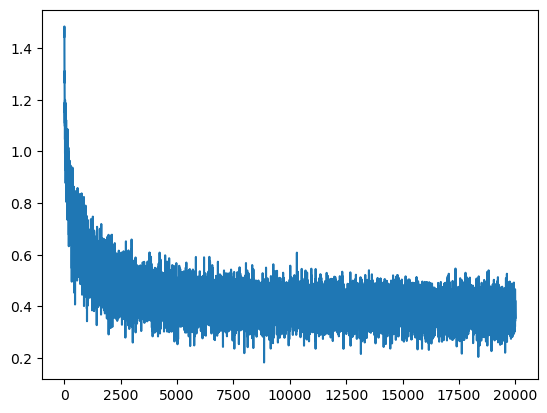

In [10]:
plt.plot(lossi)

The ideal random distribution will have the same probabilities for all the variables which will be 1/27. If we can we start from this point and the learn better probabilites it will be less computationally expensive. To do this we clip the weights of the neural nework by a constant, say 0.1

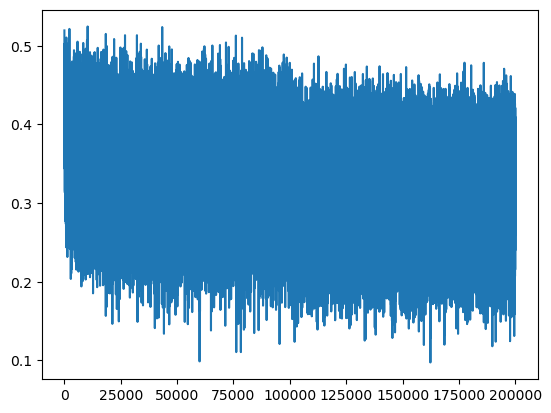

In [40]:
plt.plot(lossi)

In [14]:
@torch.no_grad() #this decorater disables gradient tracking
def split_loss(split):
    x, y = {
        "train": (Xtr, Ytr),
        "val": (Xdev, Ydev),
        "test": (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embed)
    embcat = emb.view(emb.shape[0], -1) #concat into (N, block_size*n_embed)
    h = torch.tanh(embcat @ W1 + b1) #(N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')


train 2.2974042892456055
val 2.333411931991577


#### ------BATCH NORMALIZATION-------

In [15]:
#MLP revisited with batch normalization
n_embed = 10 #number of embedding dimensions
n_hidden = 200 #number of hidden units

g = torch.Generator().manual_seed(12345)
#generate the embeddings for each of the 27 characters
C = torch.randn((vocab_size, n_embed), generator=g, requires_grad=True)
#weight matrix of the first layer
#we have forecibly normalized the weight matrix using the kaiming initialization
W1 = torch.randn((n_embed*block_size, n_hidden), generator=g, requires_grad=False) * (5/3) / ((n_embed*block_size)**0.5)
b1 = torch.randn(n_hidden, generator=g, requires_grad=True)
W2 = torch.randn((n_hidden, vocab_size), generator=g, requires_grad=False) * 0.01 
b2 = torch.randn(vocab_size, generator=g, requires_grad=False) * 0

bngain = torch.ones((1, n_hidden), requires_grad=True)
bnbias = torch.zeros((1, n_hidden), requires_grad=True)

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12297


In [16]:
import torch.nn.functional as F
#same optimization as last time
max_steps = 20000
batch_size = 32
lossi=[]

for i in range(max_steps):
    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    #forward pass
    emb = C[Xb] #embed the characters into the vectors
    embcat = emb.view(emb.shape[0], -1) #concatenate vectors
    hpreact = embcat @ W1 + b1 #hidden layer pre-activation
    hpreact = bngain*(hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias #batch normalization layer 
    h = torch.tanh(hpreact) #hidden layer
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb) #loss function

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = 0.1 if i<100000 else 0.01 #step learning rate decay
    for p in parameters:
        p.data += -lr*p.grad

    #track statistics
    if i%1000 == 0:
        print(f"{i:7d}/{max_steps:7d} : {loss.item():.4f}")
    lossi.append(loss.log10().item())



      0/  20000 : 3.3162
   1000/  20000 : 2.6977
   2000/  20000 : 2.8449
   3000/  20000 : 2.4865
   4000/  20000 : 2.2115
   5000/  20000 : 2.2735
   6000/  20000 : 2.2750
   7000/  20000 : 2.1497
   8000/  20000 : 1.9952
   9000/  20000 : 2.1704
  10000/  20000 : 2.4477
  11000/  20000 : 2.3375
  12000/  20000 : 2.6352
  13000/  20000 : 2.5314
  14000/  20000 : 2.2607
  15000/  20000 : 2.2338
  16000/  20000 : 1.8681
  17000/  20000 : 2.2543
  18000/  20000 : 1.9265
  19000/  20000 : 2.2513


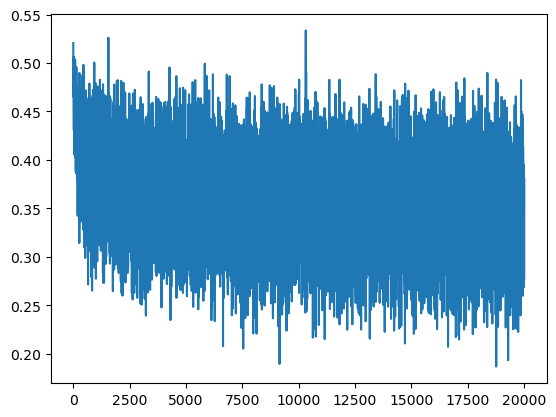

In [17]:
plt.plot(lossi)

In [18]:
@torch.no_grad() #this decorater disables gradient tracking
def split_loss(split):
    x, y = {
        "train": (Xtr, Ytr),
        "val": (Xdev, Ydev),
        "test": (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embed)
    embcat = emb.view(emb.shape[0], -1) #concat into (N, block_size*n_embed)
    hpreact = embcat @ W1 + b1 #hidden layer pre-activation
    hpreact = bngain*(hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias #batch normalization layer 
    h = torch.tanh(hpreact) #(N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')


train 2.2219111919403076
val 2.2468183040618896


Applying batchnorm to the training creates an issue of predicting the output when a single input is given, because the network expects a batch of training samples. To rectify this, we can apply an extra training step 

In [21]:
#calibrate the batch norm at the end of the training

with torch.no_grad():
    #pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    #measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

@torch.no_grad() #this decorater disables gradient tracking
def split_loss(split):
    x, y = {
        "train": (Xtr, Ytr),
        "val": (Xdev, Ydev),
        "test": (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embed)
    embcat = emb.view(emb.shape[0], -1) #concat into (N, block_size*n_embed)
    hpreact = embcat @ W1 + b1 #hidden layer pre-activation
    hpreact = bngain*(hpreact - bnmean) / bnstd + bnbias #batch normalization layer 
    h = torch.tanh(hpreact) #(N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')


train 2.2219111919403076
val 2.2468454837799072


Or! We can calculate the mean of the whole training samples while training by calculating a running loss and running standard deviation

In [22]:
#MLP revisited with batch normalization and running loss
n_embed = 10 #number of embedding dimensions
n_hidden = 200 #number of hidden units

g = torch.Generator().manual_seed(12345)
#generate the embeddings for each of the 27 characters
C = torch.randn((vocab_size, n_embed), generator=g, requires_grad=True)
#weight matrix of the first layer
#we have forecibly normalized the weight matrix using the kaiming initialization
W1 = torch.randn((n_embed*block_size, n_hidden), generator=g, requires_grad=False) * (5/3) / ((n_embed*block_size)**0.5)
b1 = torch.randn(n_hidden, generator=g, requires_grad=True)
W2 = torch.randn((n_hidden, vocab_size), generator=g, requires_grad=False) * 0.01 
b2 = torch.randn(vocab_size, generator=g, requires_grad=False) * 0

bngain = torch.ones((1, n_hidden), requires_grad=True)
bnbias = torch.zeros((1, n_hidden), requires_grad=True)
bnmean_running = torch.zeros((1, n_hidden), requires_grad=False)
bnstd_running = torch.ones((1, n_hidden), requires_grad=False)


parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12297


In [23]:
import torch.nn.functional as F
#same optimization as last time
max_steps = 20000
batch_size = 32
lossi=[]

for i in range(max_steps):
    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    #forward pass
    emb = C[Xb] #embed the characters into the vectors
    embcat = emb.view(emb.shape[0], -1) #concatenate vectors
    hpreact = embcat @ W1 + b1 #hidden layer pre-activation
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain*(hpreact - bnmeani) / bnstdi + bnbias #batch normalization layer 
    
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    
    h = torch.tanh(hpreact) #hidden layer
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb) #loss function

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = 0.1 if i<100000 else 0.01 #step learning rate decay
    for p in parameters:
        p.data += -lr*p.grad

    #track statistics
    if i%1000 == 0:
        print(f"{i:7d}/{max_steps:7d} : {loss.item():.4f}")
    lossi.append(loss.log10().item())



      0/  20000 : 3.3162
   1000/  20000 : 2.6977
   2000/  20000 : 2.8449
   3000/  20000 : 2.4865
   4000/  20000 : 2.2115
   5000/  20000 : 2.2735
   6000/  20000 : 2.2750
   7000/  20000 : 2.1497
   8000/  20000 : 1.9952
   9000/  20000 : 2.1704
  10000/  20000 : 2.4477
  11000/  20000 : 2.3375
  12000/  20000 : 2.6352
  13000/  20000 : 2.5314
  14000/  20000 : 2.2607
  15000/  20000 : 2.2338
  16000/  20000 : 1.8681
  17000/  20000 : 2.2543
  18000/  20000 : 1.9265
  19000/  20000 : 2.2513


In [24]:
@torch.no_grad() #this decorater disables gradient tracking
def split_loss(split):
    x, y = {
        "train": (Xtr, Ytr),
        "val": (Xdev, Ydev),
        "test": (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embed)
    embcat = emb.view(emb.shape[0], -1) #concat into (N, block_size*n_embed)
    hpreact = embcat @ W1 + b1 #hidden layer pre-activation
    hpreact = bngain*(hpreact - bnmean_running) / bnstd_running + bnbias #batch normalization layer 
    h = torch.tanh(hpreact) #(N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.2258713245391846
val 2.250460147857666
